# MeerKAT Uptime Calculations from Outlogs

This notebook was built to take a series of log text files for the MeerKAT array and determine how much time the array actively spends making observations using python. The primary objective is to help inform SETI commensal observation plans. This gives us a rough sense of how much time commensal observations can expect to obtain, assuming the outlogs are somewhat representative of how the array will be used going forward. The idea is to diagnose past use to inform future projections.

#### Section 1: Loading
To begin, I imported the necessary packages, a few custom functions, loaded the data files and parsed out the relevant text strings from each line of each file. 

#### Section 2: Tabulating and Filtering
I then built a dataframe table containing the relevant information on each observation. I filtered the dataframe table down based on the description of the scripts being run for each observation, and appended some additional information about each observation not directly listed in the outlogs but inferred from the timestamps.

#### Section 3: Probing the Data
With the pared down and neatly packaged table containing mostly only science objectives at this point I could draw some information from the data. This is where the uptime numbers are calculated. Scroll down to this section for the bottom line.

#### Section 4: Plotting
Everyone appreciates visual representations of the data. In this section I put together a few plots to display the uptime and number of observations by date and by weekday. 

#### Section 5: Further Refinement for BLUSE
This last section is an addendum, paring down the data even more to focus on pool resources relevant to bluse and seeing how that compares to some of the results above.

## Section 1: Loading

In [1]:
import os
import glob
import time
import pandas as pd
import numpy as np
from math import trunc
from datetime import datetime
from datetime import date
from datetime import timedelta
from astropy.time import Time
import astropy.units as u
import astropy.coordinates as coord

This next line finds the text files. Note that this assumes all the text files are within the same folder as the jupyter notebook.

In [2]:
os.chdir('C:\\Users\\sirsp\\Jupyter_Notebook\\VLA')
outlogs=sorted(glob.glob('vla_output_*.dat'))

This next cell contains some custom functions for moving between a datetime object and the date/time strings as formatted in the text files.

In [3]:
# date and time string to a datetime object
def timestr_to_datetime(duration):
    return datetime.strptime(duration,'%H:%M:%S.%f')

def datetime_to_timestr(duration):
    return duration.strftime('%H:%M:%S.%f')

def dtdate_to_datestr(duration):
    return duration.strftime('%Y-%m-%d')

def dtstr_to_datetime(date_and_time):
    return datetime.strptime(date_and_time,'%Y-%m-%d %H:%M:%S.%f')

def datestr_to_datetime(date):
    return datetime.strptime(date,'%Y-%m-%d')

def timestr_to_secs(item):
    secs = float(item.split(':')[0])*3600+float(item.split(':')[1])*60+float(item.split(':')[2].replace(',','.'))
    return secs

def datetime_to_secs(item):
    return timestr_to_secs(datetime_to_timestr(item))

def secs_to_timestr(secs):
    h = trunc(secs/3600)
    m = trunc(secs/60-60*h)
    s = secs-3600*h-60*m
    return '%02d:%02d:%.6f' % (h, m, s)

In [4]:
dat = open(outlogs[0],'r').readlines()
PROJID=[]
SRC=[]
RA=[]
DEC=[]
MJD_Start=[]
MJD_End=[]
NANT=[]
date_start=[]
time_start=[]
date_end=[]
time_end=[]
Receiver=[]
Channels=[]
for line in dat:
    PROJID.append(line.split('PROJID= ')[1].split(' ')[0])
    SRC.append(line.split('SRC= ')[1].split(' ')[0])
    RA.append(line.split('(ra,dec)=( ')[1].split(' ')[0])                    # degrees
    DEC.append(line.split('(ra,dec)=( ')[1].split(' , ')[1].split(' ')[0])   # degrees
    MJD_Start.append(line.split('MJD= ')[1].split(' ')[0])
    MJD_End.append(line.split('MJD= ')[1].split(' - ')[1].split(' ')[0])
    NANT.append(line.split('NANT= ')[1].split(' ')[0])
    if line.split('NANT= ')[1].split(' ')[-1]:
        Receiver.append(line.split('NANT= ')[1].split(' ')[2])
        Channels.append(line.split('[')[1].split(']')[0])
    else:
        Receiver.append('None')
        Channels.append('None')
dt_start = Time(MJD_Start,format='mjd').to_value('datetime')
dt_end = Time(MJD_End,format='mjd').to_value('datetime')
for date in Time(MJD_Start,format='mjd').to_value('iso'):
    date_start.append(date.split(' ')[0])
    time_start.append(date.split(' ')[1])
for date in Time(MJD_End,format='mjd').to_value('iso'):
    date_end.append(date.split(' ')[0])
    time_end.append(date.split(' ')[1])
print(len(dat))

581


In [5]:
dat[0]

'PROJID= 38678178 SRC= ZTF21aaocrlm_2 (ra,dec)=( 122.730 , -6.047 ) deg | MJD= 59302.978253 - 59302.978945 | NANT= 27  6GHz [4488.0, 5488.0]\n'

In [6]:
a = PROJID
b = SRC
c = RA
d = DEC
e = MJD_Start
f = MJD_End
g = NANT
h = Receiver
i = Channels
j = date_start
k = time_start
l = date_end
m = time_end
n = dt_start
o = dt_end
Data_set = np.c_[a,b,c,d,e,f,g,h,i,j,k,l,m,n,o]
df = pd.DataFrame(np.column_stack([a,b,c,d,e,f,g,h,i,j,k,l,m,n,o]), 
                  columns=['PROJID', 'SRC', 'RA','DEC','MJD_Start','MJD_End','NANT', 'Receiver','Channels',
                           'Start_Date','Start_Time','End_Date','End_Time','Datetime_Start','Datetime_End'])
df['RA']=df['RA'].astype(float)
df['DEC']=df['DEC'].astype(float)
df['MJD_Start']=df['MJD_Start'].astype(float)
df['MJD_End']=df['MJD_End'].astype(float)
df['NANT']=df['NANT'].astype(int)
df['Obs_Secs']=[(df.Datetime_End[x] - df.Datetime_Start[x]).total_seconds() for x in range(len(df))]
df

,PROJID,SRC,RA,DEC,MJD_Start,MJD_End,NANT,Receiver,Channels,Start_Date,Start_Time,End_Date,End_Time,Datetime_Start,Datetime_End,Obs_Secs
0,38678178,ZTF21aaocrlm_2,122.730,-6.047,59302.978253,59302.978945,27,6GHz,"4488.0, 5488.0",2021-03-29,23:28:41.059,2021-03-29,23:29:40.848,2021-03-29 23:28:41.059200,2021-03-29 23:29:40.848000,59.7888
1,38678178,ZTF21aaocrlm_2,122.730,-6.047,59302.978945,59302.979638,27,6GHz,"4488.0, 5488.0",2021-03-29,23:29:40.848,2021-03-29,23:30:40.723,2021-03-29 23:29:40.848000,2021-03-29 23:30:40.723200,59.8752
2,38678178,ZTF21aaocrlm_2,122.730,-6.047,59302.979638,59302.980330,27,6GHz,"4488.0, 5488.0",2021-03-29,23:30:40.723,2021-03-29,23:31:40.512,2021-03-29 23:30:40.723200,2021-03-29 23:31:40.512000,59.7888
3,38678178,ZTF21aaocrlm_2,122.730,-6.047,59302.981023,59302.981715,27,6GHz,"4488.0, 5488.0",2021-03-29,23:32:40.387,2021-03-29,23:33:40.176,2021-03-29 23:32:40.387200,2021-03-29 23:33:40.176000,59.7888
4,38678178,ZTF21aaocrlm_2,122.730,-6.047,59302.981715,59302.982408,27,6GHz,"4488.0, 5488.0",2021-03-29,23:33:40.176,2021-03-29,23:34:40.051,2021-03-29 23:33:40.176000,2021-03-29 23:34:40.051200,59.8752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,Unknown,3C345,250.745,39.810,59303.655347,59303.655694,27,None,"22024.0, 22024.0, 22024.0, 22024.0",2021-03-30,15:43:41.981,2021-03-30,15:44:11.962,2021-03-30 15:43:41.980800,2021-03-30 15:44:11.961600,29.9808
577,Unknown,3C345,250.745,39.810,59303.655694,59303.656042,27,None,"22024.0, 22024.0, 22024.0, 22024.0",2021-03-30,15:44:11.962,2021-03-30,15:44:42.029,2021-03-30 15:44:11.961600,2021-03-30 15:44:42.028800,30.0672
578,Unknown,3C345,250.745,39.810,59303.656042,59303.656389,27,None,"22024.0, 22024.0, 22024.0, 22024.0",2021-03-30,15:44:42.029,2021-03-30,15:45:12.010,2021-03-30 15:44:42.028800,2021-03-30 15:45:12.009600,29.9808
579,Unknown,3C345,250.745,39.810,59303.656389,59303.656736,27,None,"22024.0, 22024.0, 22024.0, 22024.0",2021-03-30,15:45:12.010,2021-03-30,15:45:41.990,2021-03-30 15:45:12.009600,2021-03-30 15:45:41.990400,29.9808


In [7]:
# Set observation duration benchmark for long/short observations
Ideal = 5 # minutes

# Totals

Total_Observation_Time = df['Obs_Secs'].sum()
Ave_Obs_Dur = df['Obs_Secs'].sum()/len(df)
Total_Log_Time = (df.Datetime_End[len(df)-1] - df.Datetime_Start[0]).total_seconds()
Total_Uptime = Total_Observation_Time / Total_Log_Time
Num_Short_Obs = df.loc[df['Obs_Secs'] < Ideal*60].count()[0]
Num_Long_Obs = df.loc[df['Obs_Secs'] > Ideal*60].count()[0]
Ave_Num_Obs = len(df)/(Total_Log_Time/86400)
Ave_Obs_Hours = Ave_Num_Obs * Ave_Obs_Dur/3600
Max_Dur = df['Obs_Secs'].max()
Min_Dur = df['Obs_Secs'].min()
Ave_Ants = df['NANT'].sum()/len(df)
Max_Ants = df['NANT'].max()
Min_Ants = df['NANT'].min()
X=30
LessThanXSec = len(df[df['Obs_Secs'] <X]['Obs_Secs'])
print(f'Total Number of Observations: \t\t\t\t{len(df)}')
print(f'Average Observations per Day: \t\t\t\t{Ave_Num_Obs:.1f}')
print(f'Average Observations per Hour: \t\t\t\t{Ave_Num_Obs/24:.1f}')
print(f'Average Observation Hours per Day: \t\t\t{Ave_Obs_Hours:.2f} hours.')
print(f'\nNumber of Observations Less Than {Ideal} minutes: \t\t{Num_Short_Obs} = {Num_Short_Obs/len(df)*100:.2f}%')
print(f'Number of Observations Longer Than {Ideal} minutes: \t\t{Num_Long_Obs} = {Num_Long_Obs/len(df)*100:.2f}%')
print(f'\nAverage Observation Duration: \t\t\t\t{Ave_Obs_Dur:.2f} seconds = {Ave_Obs_Dur/60:.2f} minutes = {Ave_Obs_Dur/3600:.2f} hours.')
print(f'Longest Observation Duration: \t\t\t\t{Max_Dur:.2f} seconds = {Max_Dur/60:.2f} minutes = {Max_Dur/3600:.2f} hours.')
print(f'Shortest Observation Duration: \t\t\t\t{Min_Dur} seconds.')
print(f'\t\t\t\t\t\t\t[There were {LessThanXSec} "Observations" Less Than {X} seconds.]')
print(f'\nAverage Number of Antennas In Use: \t\t\t{Ave_Ants:.0f} antennas.')
print(f'Maximum Number of Antennas In Use: \t\t\t{Max_Ants:.0f} antennas.')
print(f'Minimum Number of Antennas In Use: \t\t\t{Min_Ants:.0f} antennas.')
print(f'\nTotal Observation Time: \t\t\t\t{Total_Observation_Time:.2f} seconds', 
      f'= {Total_Observation_Time/3600:.2f} hours = {Total_Observation_Time/86400:.2f} days.')
print(f'Total Operational Time: \t\t\t\t{Total_Log_Time:.2f} seconds', 
      f'= {Total_Log_Time/3600:.2f} hours = {Total_Log_Time/86400:.2f} days.')
print(f'\nTotal Uptime: \t\t\t\t\t\t{Total_Uptime*100:.2f}%')

Total Number of Observations: 				581
Average Observations per Day: 				855.9
Average Observations per Hour: 				35.7
Average Observation Hours per Day: 			22.61 hours.

Number of Observations Less Than 5 minutes: 		551 = 94.84%
Number of Observations Longer Than 5 minutes: 		30 = 5.16%

Average Observation Duration: 				95.08 seconds = 1.58 minutes = 0.03 hours.
Longest Observation Duration: 				598.41 seconds = 9.97 minutes = 0.17 hours.
Shortest Observation Duration: 				4.0608 seconds.
							[There were 79 "Observations" Less Than 30 seconds.]

Average Number of Antennas In Use: 			27 antennas.
Maximum Number of Antennas In Use: 			27 antennas.
Minimum Number of Antennas In Use: 			27 antennas.

Total Observation Time: 				55242.00 seconds = 15.35 hours = 0.64 days.
Total Operational Time: 				58650.91 seconds = 16.29 hours = 0.68 days.

Total Uptime: 						94.19%


In [9]:
ch2=0
ch4=0
unknown=0
for c in df.Channels:
    if len(c.split(','))==2:
        ch2+=1
    elif len(c.split(','))==4:
        ch4+=1
    else:
        unknown+=1
Tot_ch = ch2+ch4+unknown
print('Total number of observations: \t\t\t',Tot_ch)
print('Number of observations using 2 channels: \t',ch2,f'= {ch2/Tot_ch*100:.2f}%')
print('Number of observations using 4 channels: \t',ch4,f'= {ch4/Tot_ch*100:.2f}%')
print('Number of observations using unknown channels: \t',unknown)

Total number of observations: 			 581
Number of observations using 2 channels: 	 479 = 82.44%
Number of observations using 4 channels: 	 101 = 17.38%
Number of observations using unknown channels: 	 1


In [10]:
print('Number of unique project IDs: ', len(sorted(set(df.PROJID))))
print('\nProject ID list:\n',sorted(set(df.PROJID)))

Number of unique project IDs:  9

Project ID list:
 ['1378178', '28850329', '37594215', '38678178', '38678198', '39306874', '39308369', '39308595', 'Unknown']


In [11]:
print('Number of unique source names: ', len(sorted(set(df.SRC))))
print('\nSource list:\n',sorted(set(df.SRC)))

Number of unique source names:  38

Source list:
 ['0137+331=3C48', '1331+305=3C286', '1339+2955BF', '3C147', '3C273', '3C286', '3C345', 'J0112+2244', 'J0431+2037', 'J0713+4349', 'J0744-0629', 'J0854+2006', 'J0949+6614', 'J1206+3941', 'J1310+3220', 'J1329+3154', 'J1330+2509', 'J1331+3030', 'J1407+2827', 'J1417+4607', 'J1419+5423', 'J1436+6336', 'J1613+3412', 'J1624+5741', 'J1638+5720', 'J1642+6856', 'J1740+5211', 'J1800+7828', 'J1927+6117', 'J2115+2933', 'NGC4869', 'PTF12dam', 'SGRB210323A', 'SN', 'TMC-1', 'Z21aafnunh_24a', 'ZTF21aadatfg_2', 'ZTF21aaocrlm_2']


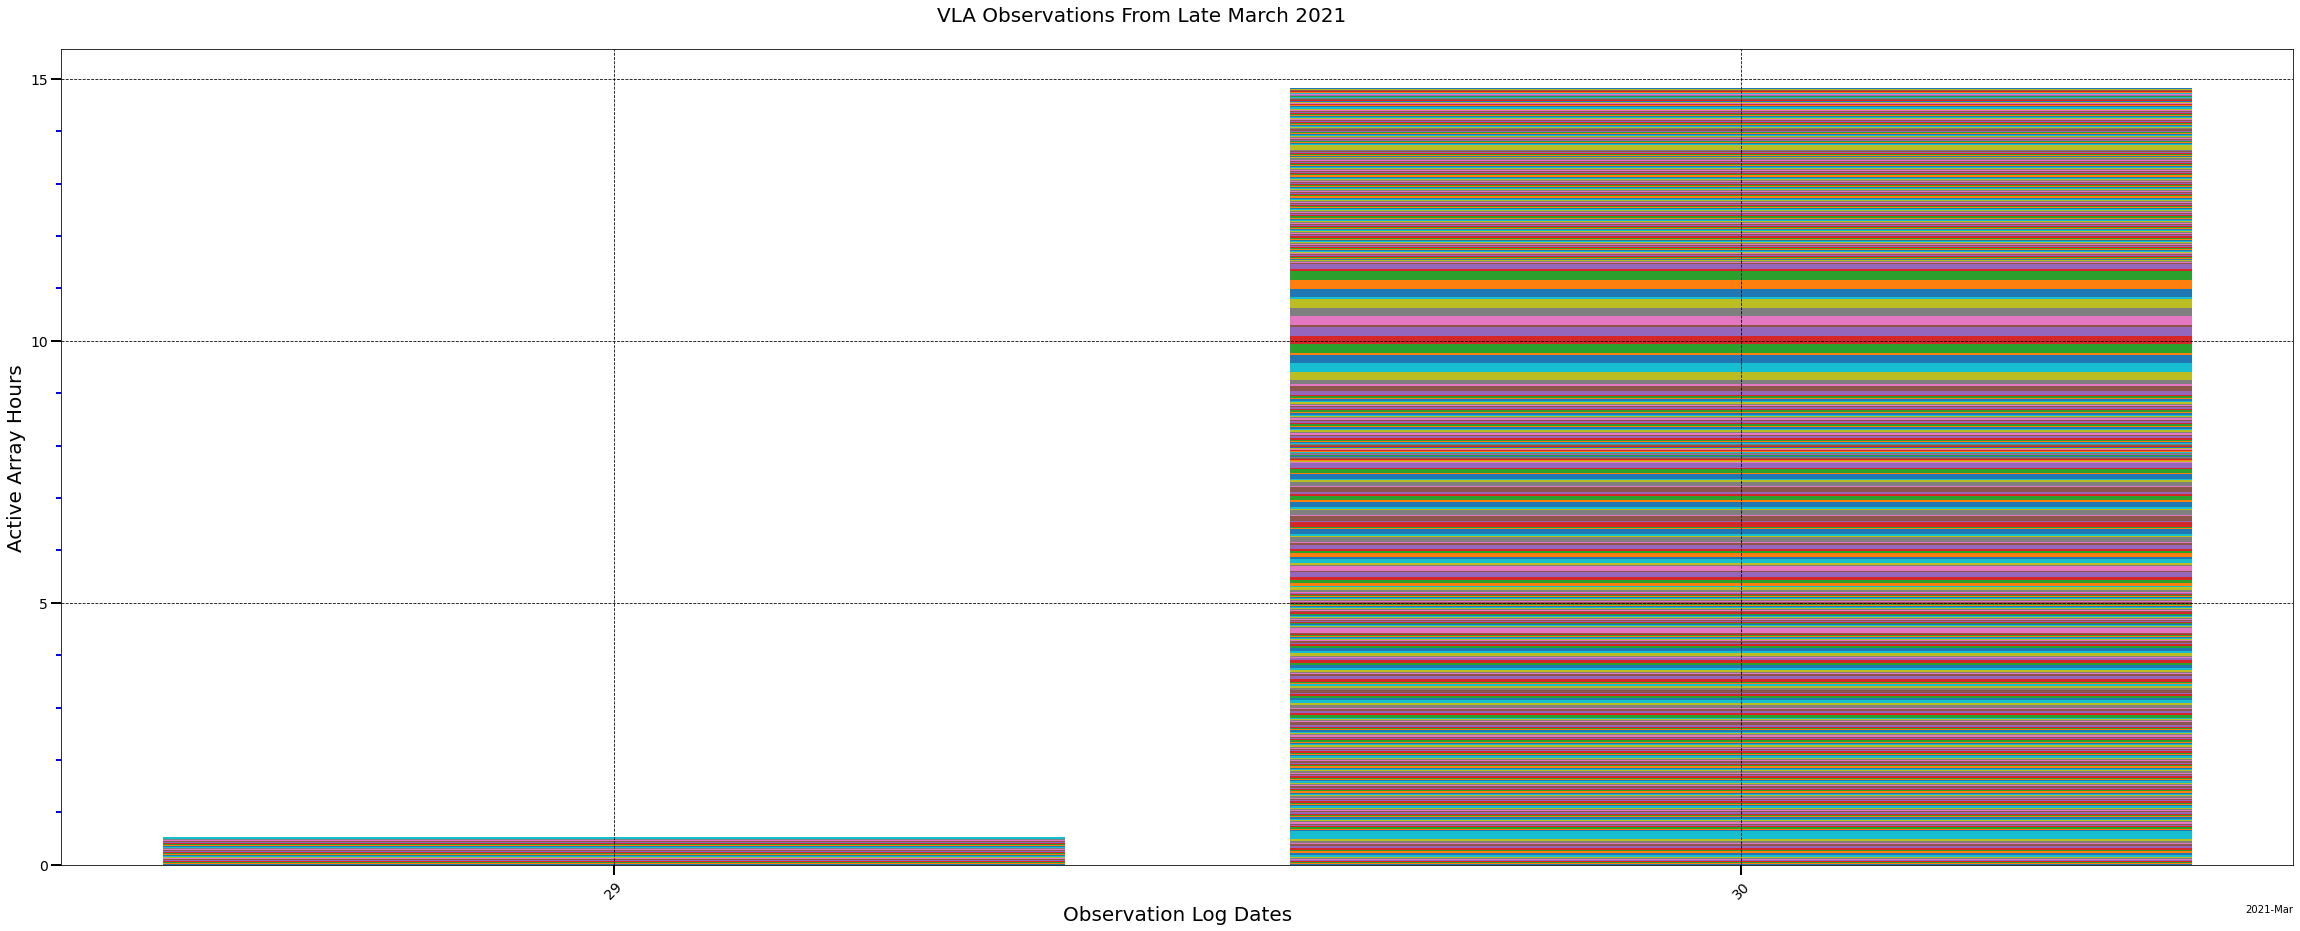

In [12]:
# Plot the number of observations taken each day over the log period.
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
fig,ax = plt.subplots(figsize=(40,15))

# Set data to be plotted
Dates=[]
for row in df.itertuples():
    Dates.append(pd.to_datetime(row.Start_Date).date())   # Get the dates in a plot-friendly format
Dates = sorted(list(set(Dates)))
Upbydate = df.groupby('Start_Date').sum()['Obs_Secs'].divide(3600) # Total time of observations per day in seconds
num_obs = df['Start_Date'].value_counts().sort_index()
ave_ant_per_day = df.groupby('Start_Date').sum()['NANT']/num_obs

# Set colormapping
# interval = 4
# ants = np.arange(int(min(ave_ant_per_day)),int(max(ave_ant_per_day))+interval,interval)
# cmap = plt.cm.RdYlGn
# norm = matplotlib.colors.Normalize(vmin=min(ants), vmax=max(ants))
# colors=cmap(norm(ave_ant_per_day))
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# cbar=fig.colorbar(sm,pad=0.01)
# cbar.set_ticks(ants)
# cbar.set_ticklabels(ants)
# cbar.ax.set_title('Antennas',y=-0.04)

# Make the bar plot, overlaid with max hours and average observation hours lines
for date in sorted(set(Dates)):
    bottom=0
    for y,secs in enumerate(df[[df.Datetime_Start[x].date()==date for x in range(len(df))]].Obs_Secs.divide(3600)):
        plt.bar(date,secs,bottom=bottom)
        bottom=bottom+secs
#     plt.bar(Dates, Upbydate,zorder=2,edgecolor='black',color=colors,label='Total Observation Hours per Day',alpha=0.8)
# plt.hlines(y=24,xmin=18531,zorder=3,xmax=18692,color='green',linestyle='dotted',linewidth=2,label='24 hours')
# plt.hlines(y=Ave_Obs_Hours,zorder=4,xmin=18531,xmax=18692,color='purple',linestyle='dashed',linewidth=1,label='Total Average Uptime')
# plt.scatter(Dates,Monthly_Uptime,zorder=5,marker='_',color='red',linewidth=3,label='Monthly Average Uptime')


# matplotlib date plotting axis stuff
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(1))
locator = mdates.AutoDateLocator(minticks=1, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
days = mdates.DayLocator()
ax.xaxis.set_minor_locator(days)

# make it pretty
plt.xticks(rotation='45',size=14)
plt.yticks(size=14)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=5, color='blue')
plt.grid(axis='both', which='major', color='black', linestyle='--')
# ax.set_xlim(18541,18690)

# set axis labels and title
plt.xlabel('Observation Log Dates', fontsize=20)
plt.ylabel('Active Array Hours', fontsize=20)
fig.suptitle('VLA Observations From Late March 2021', fontsize=20, y=0.92)
# legend=plt.legend(prop={'size':20})
# legend.get_frame().set_linewidth(3)
# legend.get_frame().set_edgecolor('black')
# legend.get_frame().set_alpha(1)
plt.show()

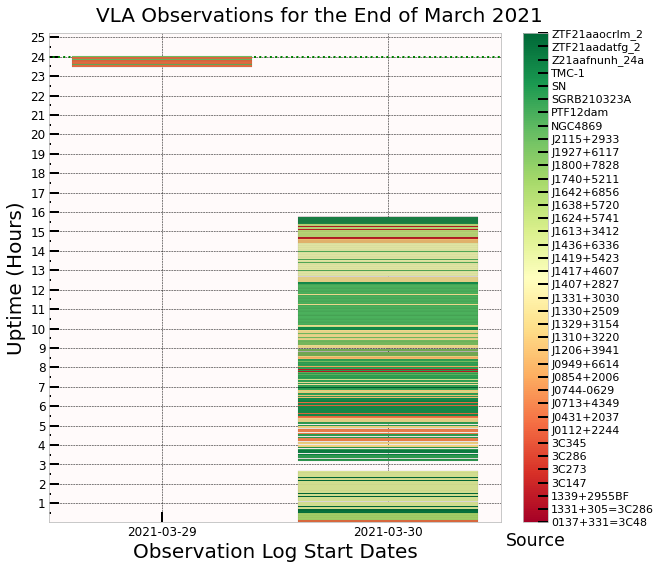

In [46]:
import matplotlib
from matplotlib import dates as mdates
from matplotlib.ticker import MultipleLocator
fig,ax = plt.subplots(figsize=(10,9))

m = len(sorted(set(df.SRC)))
SRC = np.arange(0,m,1)
cmap = plt.cm.RdYlGn
norm = matplotlib.colors.Normalize(vmin=0, vmax=m-1)
# color=cmap(norm(np.linspace(0,1,len(df))))
colors = [float(hash(s) % 256) / 256 for s in df.SRC] 
color = cmap([colors[x] for x in range(len(colors))])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar=fig.colorbar(sm,pad=0.04)
cbar.set_ticks(SRC)
cbar.set_ticklabels(sorted(set(df.SRC)))
cbar.ax.set_title('Source',y=-0.06)
cbar.ax.tick_params(labelsize=11, width=2,length=10)

for i in range(len(df)):
    Delta = (df.Datetime_End[i] - df.Datetime_Start[i]).seconds
    plt.bar(df.Start_Date[i],Delta/3600,bottom=timestr_to_secs(df.Start_Time[i])/3600,color=color[i],
            edgecolor='black',linewidth=0.05,zorder=10)
plt.hlines(y=24,xmin=-1,zorder=3,xmax=2,color='green',linestyle='dotted',linewidth=2,label='24 hours')
ax.set_xlim(-0.5,1.5)
plt.grid(axis='both', which='major', color='black', linestyle='--',zorder=1)

ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
plt.xticks(size=12)
plt.yticks(size=12)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.set_facecolor('snow')
plt.xlabel('Observation Log Start Dates', fontsize=20)
plt.ylabel('Uptime (Hours)', fontsize=20)
fig.suptitle('VLA Observations for the End of March 2021', fontsize=20, y=0.92)
plt.show()

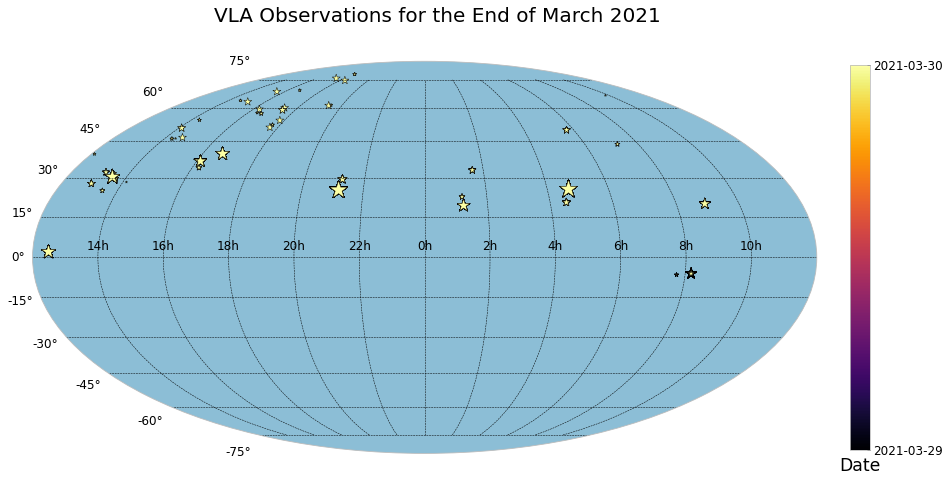

In [35]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection="mollweide")

Dates = sorted(set(df.Start_Date))

for d,date in enumerate(Dates):
    cmap=plt.cm.inferno
    norm = matplotlib.colors.Normalize(vmin=0, vmax=len(Dates))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    colors=cmap(norm(np.linspace(0,len(Dates),len(Dates))))
    ra = coord.Angle(df[df['Start_Date'].str.contains(date)]['RA']*u.degree)
    ra = ra.wrap_at(180*u.degree)
    dec = coord.Angle(df[df['Start_Date'].str.contains(date)]['DEC']*u.degree)
    targets = df[df['Start_Date'].str.contains(date)]['SRC']
    sizes = [list(targets).count(i)*5 for i in targets]
    ax.scatter(ra.radian, dec.radian,s=sizes,marker='*',edgecolor='black',linewidth=0.5,color=colors[d])
    
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])

cbar=fig.colorbar(sm,pad=0.04,fraction=0.023)
cbar.set_ticks(np.linspace(0,len(Dates),len(Dates)))
cbar.set_ticklabels(sorted(set(Dates)))
cbar.ax.set_title('Date',y=-0.07)

plt.grid(axis='both', which='major', color='black', linestyle='--')
ax.set_facecolor('#8CBED6')
fig.suptitle('VLA Observations for the End of March 2021', fontsize=20, y=0.85)
plt.show()

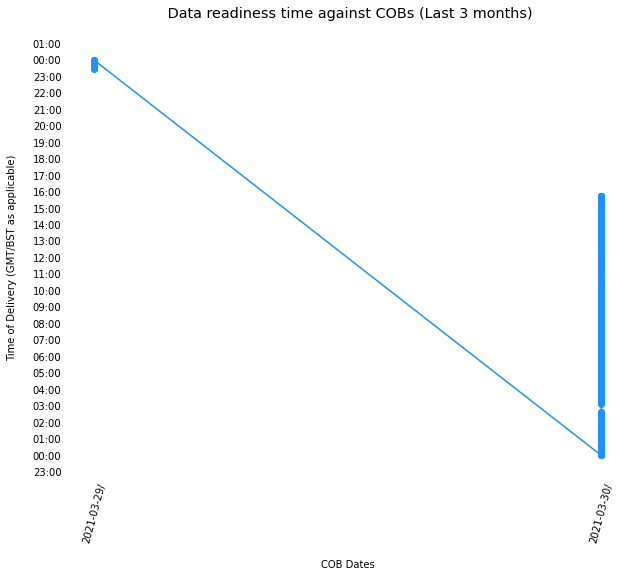

In [16]:
from matplotlib import dates as mdates

x = mdates.datestr2num(df.Start_Date)  #COB is date in "01-MAR-2020" format- convert it to madates type
y = mdates.datestr2num(df.Start_Time) #CALV14 is time in "21:04"  Format- convert it to madates type

fig, ax = plt.subplots(figsize=(10,8))
ax.clear() # Clear the axes
ax.plot(x, y, 'bo-', color = 'dodgerblue') #Plot the data
plt.xticks(x,rotation = '75')
ax.yaxis_date()
ax.xaxis_date()

yfmt = mdates.DateFormatter('%H:%M') 
xfmt = mdates.DateFormatter('%Y-%m-%d/')
ax.yaxis.set_major_formatter(yfmt)
ax.xaxis.set_major_formatter(xfmt)
ax.yaxis.set_major_locator(mdates.HourLocator(interval=1))   # Every 1 Hour
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))   # Every 1 Day

####### Name the x,y labels, titles and beautify the plot #######
plt.style.use('bmh')
plt.xlabel('\nCOB Dates')
plt.ylabel('Time of Delivery (GMT/BST as applicable)\n')
plt.title(" Data readiness time against COBs (Last 3 months)\n")
plt.rcParams["font.size"] = "12" #Change the font 
# plt.rcParams["font.family"] = "Times New Roman" # Set the font type if needed
plt.tick_params(left = False, bottom = False, labelsize = 10) #Remove ticks, make tick labelsize 10
plt.box(False)

plt.show()